In [1]:
# %reset -f

# import numpy as np
# import scipy.io as spi
# import tensorflow as tf
# import matplotlib.pyplot as plt

# dt = 0.01
# min_t = 0
# max_t = 10

# t = np.arange(min_t, max_t, dt)
# lt = t.shape[0]

# test_samples = 11000

# def rkm(y1, y2, z, f, t):
#     h = dt

#     F1 = lambda Y: Y[2]
#     F2 = lambda Y: (1/m)*(f-(c*Y[2]+k*Y[1]+(1-kr)*Qy*Y[3]))
#     F3 = lambda Y: (1/Dy)*(alpha*Y[2]-gamma*Y[3]*np.abs(Y[2])*np.abs(Y[3])**(eta-1)-beta*Y[2]*(np.abs(Y[3]))**eta)    

#     k0 = h*F1([t, y1, y2, z]);
#     l0 = h*F2([t, y1, y2, z]);
#     m0 = h*F3([t, y1, y2, z]);

#     k1 = h*F1([t+0.5*h, y1+0.5*k0, y2+0.5*l0, z+0.5*m0]);
#     l1 = h*F2([t+0.5*h, y1+0.5*k0, y2+0.5*l0, z+0.5*m0]);
#     m1 = h*F3([t+0.5*h, y1+0.5*k0, y2+0.5*l0, z+0.5*m0]);

#     k2 = h*F1([t+0.5*h, y1+0.5*k1, y2+0.5*l1, z+0.5*m1]);
#     l2 = h*F2([t+0.5*h, y1+0.5*k1, y2+0.5*l1, z+0.5*m1]);
#     m2 = h*F3([t+0.5*h, y1+0.5*k1, y2+0.5*l1, z+0.5*m1]);

#     k3 = h*F1([t, y1+k2, y2+l2, z+m2]);
#     l3 = h*F2([t, y1+k2, y2+l2, z+m2]);
#     m3 = h*F3([t, y1+k2, y2+l2, z+m2]);

#     y1 = y1+(1/6)*(k0+2*k1+2*k2+k3);
#     y2 = y2+(1/6)*(l0+2*l1+2*l2+l3);
#     z = z+(1/6)*(m0+2*m1+2*m2+m3);
    
#     return y1, y2, z

# y1 = np.zeros([lt, test_samples])+0.005
# y2 = np.zeros([lt, test_samples])+0.001
# z = np.zeros([lt, test_samples])+0.001

# l = 0.1
# s = 50

# mean = np.zeros([lt,])
# cov = np.zeros([lt,lt])

# f = np.zeros([lt, test_samples])
# for i in range(0,lt):
#     for j in range(i,lt):
#         cov[i,j] = (s**2)*np.exp(-1*((t[i]-t[j])**2)/(2*l**2))
#         cov[j,i] = cov[i,j]    

# f = np.random.multivariate_normal(mean, cov, test_samples).T
    
# m = 6800; c = 3740; k = 232000
# Qy = 0.05*m*9.81; kr = (1/6); alpha = 1
# beta = 0.5; gamma = 0.5; Dy = 0.013; eta = 2 

# for i in range(0, test_samples):
#     if i%1000 ==  0 or i == test_samples-1: print('sample number  = ', i) 
#     for j in range(1, lt):
#         y1[j, i], y2[j, i], z[j, i] = rkm(y1[j-1, i], y2[j-1, i], z[j-1, i], f[j-1, i], t[j-1])

# plt.plot(f[:,0])
# plt.show()
# plt.plot(y1[:,0])
# plt.show()
# plt.plot(y2[:,0])
# plt.show()
# plt.plot(z[:,0])
# plt.show()

# spi.savemat('GP_BW_data.mat',{'force': f, 'y1': y1, 'y2': y2, 'z': z, 't': t})
        

In [2]:
# %reset -f

# import time
# import numpy as np
# import scipy.io as spi
# import scipy as sp
# import tensorflow as tf
# import matplotlib.pyplot as plt

# from tensorflow import keras
# from keras.models import Model
# from keras.layers.merge import concatenate
# from tensorflow.keras import initializers, regularizers
# from tensorflow.keras.layers import Dense, Input, Lambda, Dot
# from tensorflow.keras.layers.experimental import preprocessing

# dt = 0.01
# min_t = 0
# max_t = 2

# t = np.arange(min_t, max_t, dt)
# lt = t.shape[0]

# test_n = 1000
# training_samples = [150, 250, 500, 750, 1000]
# mean_sq_error = [0, 0, 0, 0, 0]

# data = spi.loadmat('GP_BW_data.mat')
# f = data['force'][0:lt,:].T
# y = data['y1'][0:lt,:].T

# for num in range(0,5):    
#     print('Training samples: '+str(training_samples[num]))
#     train_n = training_samples[num]
#     samples = 11000
    
#     force = f

#     pointspsamples = 50
#     pointer = np.random.randint(0,lt-1,train_n*pointspsamples)
    
#     UX = np.tile(f[0:train_n,0:-1:2],(pointspsamples,1))
#     Y = np.zeros([train_n*pointspsamples,1])
#     UXY = np.zeros([train_n*pointspsamples,1])

#     for i in range(0,pointspsamples):
#         for j in range(0,train_n):
#             Y[int(train_n*i+j),0] = t[pointer[train_n*i+j]]
#             UXY[int(train_n*i+j),0] = y[j,pointer[train_n*i+j]]
    
#     ux_sensors = UX.shape[1]
#     y_sensors = Y.shape[1]

#     # # # # # # # # # # # # # # # # # # # #    

#     with tf.device('/device:cpu:0'):
        
#         def layer_dense(nodes = 1, activation_func = 'relu',
#                         kernel_init = initializers.GlorotNormal(),
#                         name = None):
#             layer = Dense(nodes, activation = activation_func,
#                          kernel_initializer = kernel_init,
#                          name = name)
#             return layer
            
        
#         def fn(x):
#             y = tf.einsum("ij,ij->i", x[0], x[1])
#             y = tf.expand_dims(y, axis=1)
#             return y

#         hidden_layer_nodes = 40

#         layer_input_a = Input(shape = (ux_sensors, ), name = "input_a")    
#         normalizer_a = preprocessing.Normalization(input_shape = [ux_sensors, ], name = '15_a')
#         normalizer_a.adapt(UX)
#         layer_15_a = normalizer_a(layer_input_a)
#         layer_20_a = layer_dense(hidden_layer_nodes, name = '20_a')(layer_15_a)
#         layer_25_a = layer_dense(hidden_layer_nodes, name = '25_a')(layer_20_a)

#         layer_input_b = Input(shape = (y_sensors, ), name = "input_b")
#         normalizer_b = preprocessing.Normalization(input_shape = [y_sensors, ], name = '15_b')
#         normalizer_b.adapt(Y)
#         layer_15_b = normalizer_b(layer_input_b)    
#         layer_20_b = layer_dense(hidden_layer_nodes, name = '20_b')(layer_15_b)
#         layer_25_b = layer_dense(hidden_layer_nodes, name = '25_b')(layer_20_b)

#         layer_35 = Lambda(fn, output_shape = [None,1], name = '35')([layer_25_a, layer_25_b])
#         layer_40 = Dense(1, activation = None,
#                          kernel_initializer = initializers.GlorotNormal(),
#                          name = '40')(layer_35)

#         model = Model(inputs = [layer_input_a, layer_input_b], outputs = layer_40)
#         # model.summary()

#         model.compile(loss = 'mse',
#                       optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
#                       metrics = 'mae')

#         start_time = time.time()
#         for i in range(0,5):
#             print('iteration = '+str(i))
#             model.fit({"input_a":UX, "input_b":Y}, UXY, epochs = 1, verbose = 1, batch_size = 128)
#             for i in range(0,999):
#                 model.fit({"input_a":UX, "input_b":Y}, UXY, epochs = 1, verbose = 0, batch_size = 128)
            
#         string = 'model_save_GP_BW_SDOF_'+str(train_n)
#         model.save(string)


Data:
sample number  =  0
sample number  =  1000
sample number  =  2000
sample number  =  3000
sample number  =  4000
sample number  =  5000
sample number  =  6000
sample number  =  7000
sample number  =  8000
sample number  =  9000
77.8593327999115
GP_BW_SDOF_150_L_0.05_S_25
7.09243631362915
GP_BW_SDOF_250_L_0.05_S_25
3.5497167110443115
GP_BW_SDOF_500_L_0.05_S_25
3.304759979248047
GP_BW_SDOF_750_L_0.05_S_25
3.321988821029663
GP_BW_SDOF_1000_L_0.05_S_25
3.2037835121154785


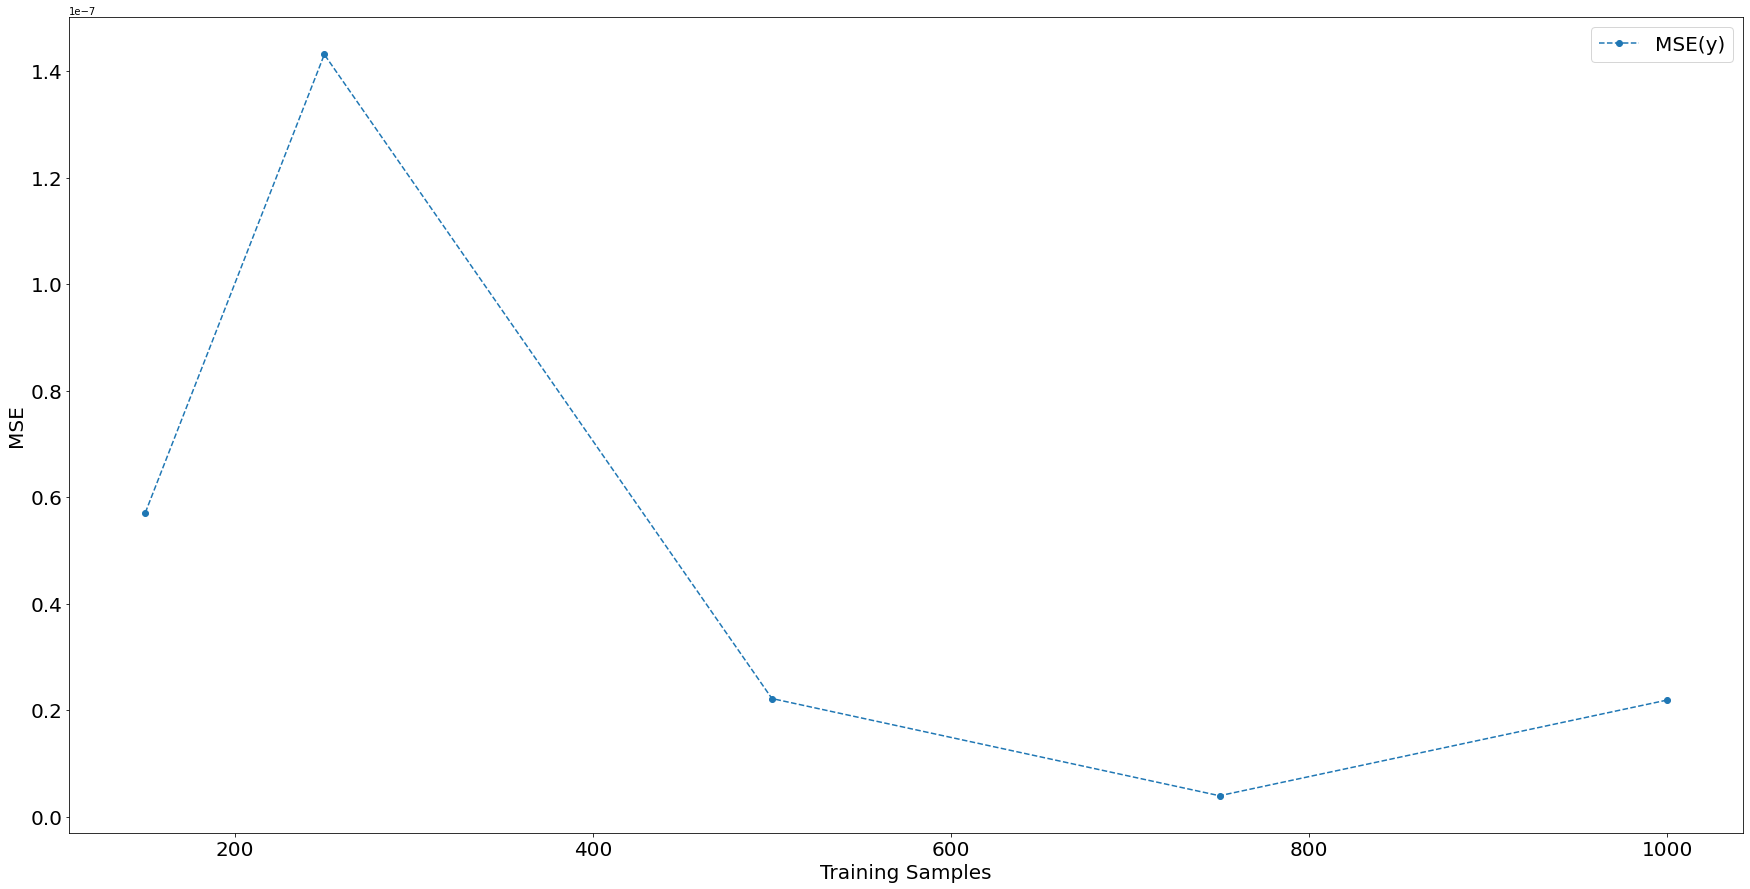


Data:
sample number  =  0
sample number  =  1000
sample number  =  2000
sample number  =  3000
sample number  =  4000
sample number  =  5000
sample number  =  6000
sample number  =  7000
sample number  =  8000
sample number  =  9000
81.98907566070557
GP_BW_SDOF_150_L_0.05_S_50
4.018112659454346
GP_BW_SDOF_250_L_0.05_S_50
3.166764736175537
GP_BW_SDOF_500_L_0.05_S_50
3.2267088890075684
GP_BW_SDOF_750_L_0.05_S_50
3.211099624633789
GP_BW_SDOF_1000_L_0.05_S_50
3.6762847900390625


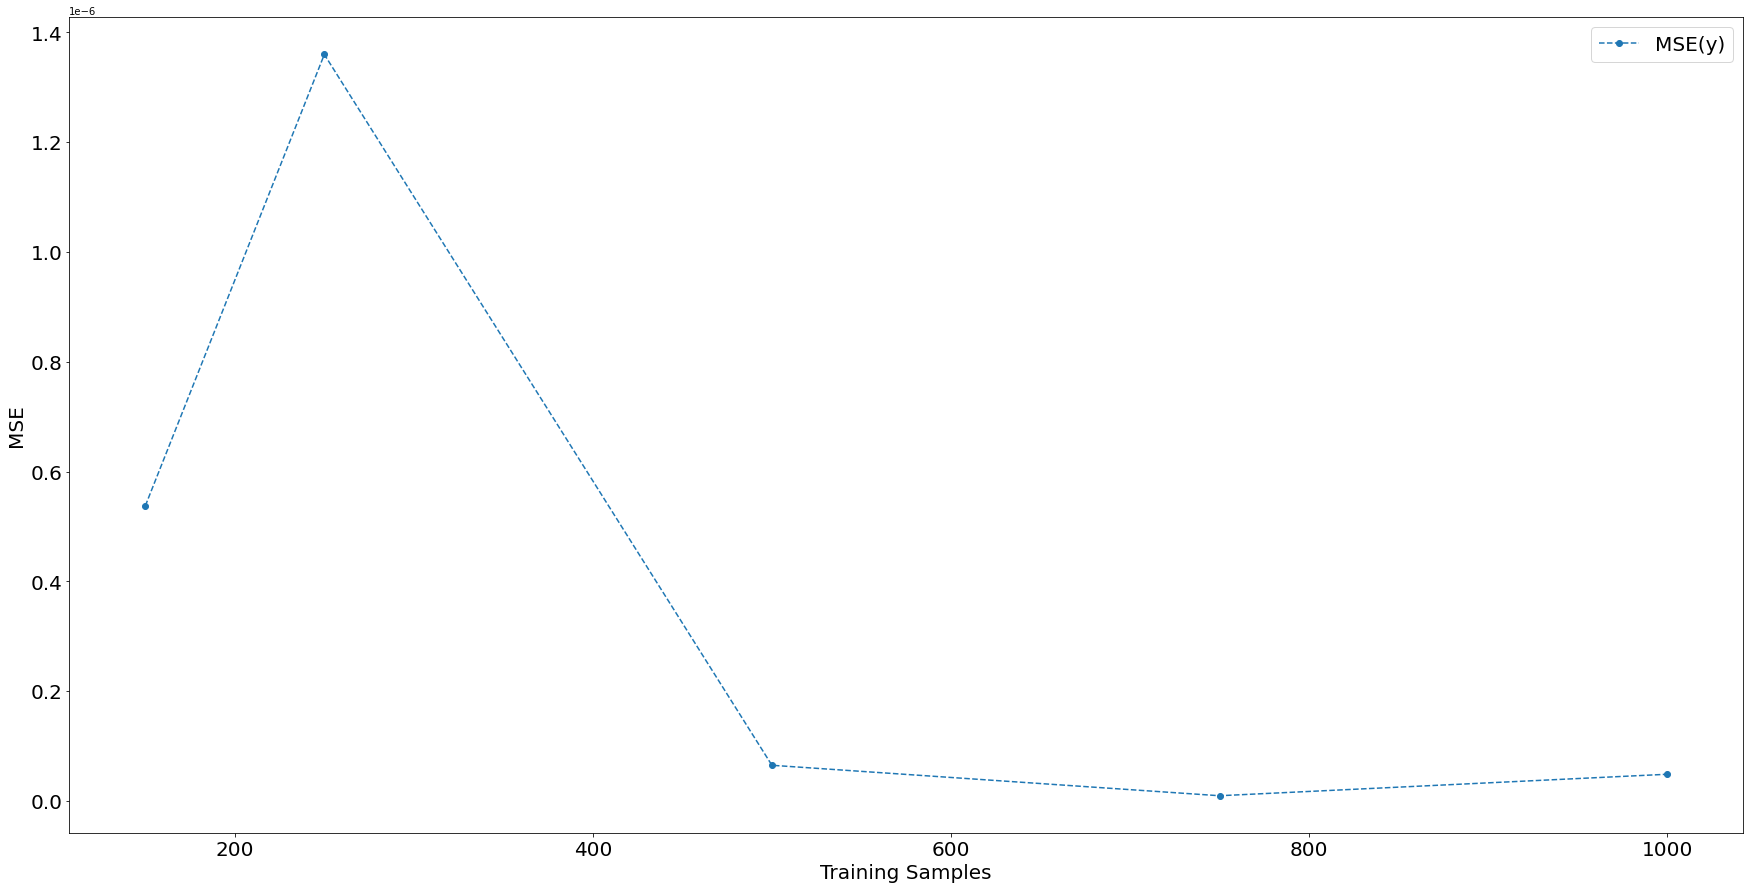


Data:
sample number  =  0
sample number  =  1000
sample number  =  2000
sample number  =  3000
sample number  =  4000
sample number  =  5000
sample number  =  6000
sample number  =  7000
sample number  =  8000
sample number  =  9000
82.7862720489502
GP_BW_SDOF_150_L_0.05_S_75
3.198087453842163
GP_BW_SDOF_250_L_0.05_S_75
3.418271780014038
GP_BW_SDOF_500_L_0.05_S_75
3.202165126800537
GP_BW_SDOF_750_L_0.05_S_75
2.944255828857422
GP_BW_SDOF_1000_L_0.05_S_75
2.9937169551849365


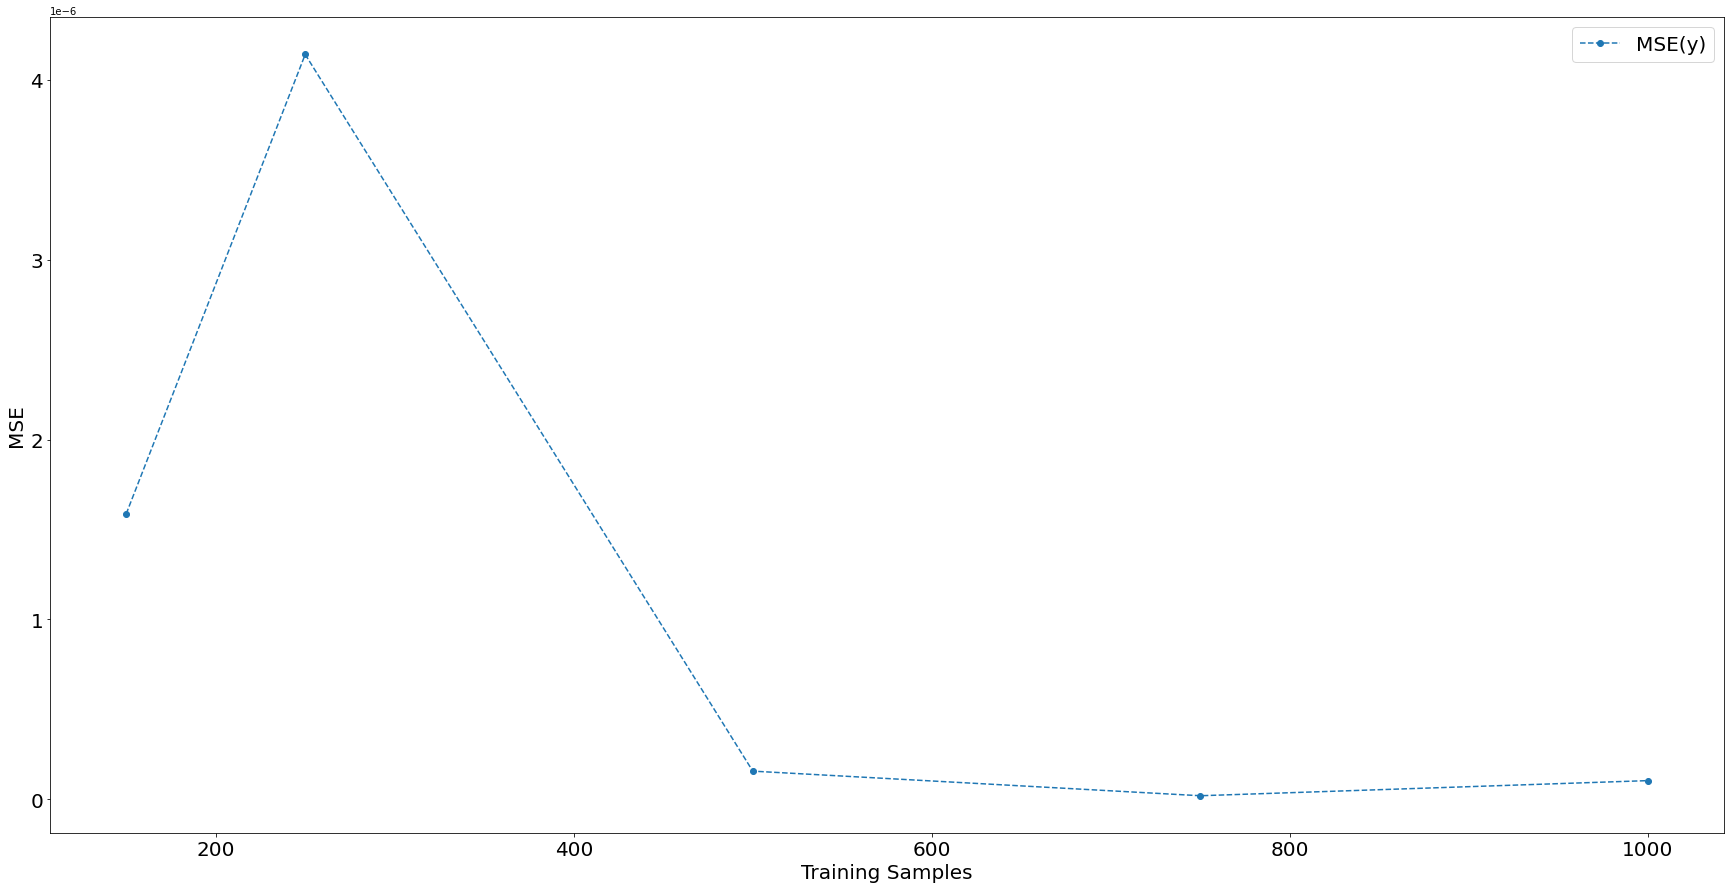


Data:
sample number  =  0
sample number  =  1000
sample number  =  2000
sample number  =  3000
sample number  =  4000
sample number  =  5000
sample number  =  6000
sample number  =  7000
sample number  =  8000
sample number  =  9000
80.04839444160461
GP_BW_SDOF_150_L_0.05_S_100
4.1369123458862305
GP_BW_SDOF_250_L_0.05_S_100
3.728325128555298
GP_BW_SDOF_500_L_0.05_S_100
4.007623672485352
GP_BW_SDOF_750_L_0.05_S_100
3.3740978240966797
GP_BW_SDOF_1000_L_0.05_S_100
3.225116491317749


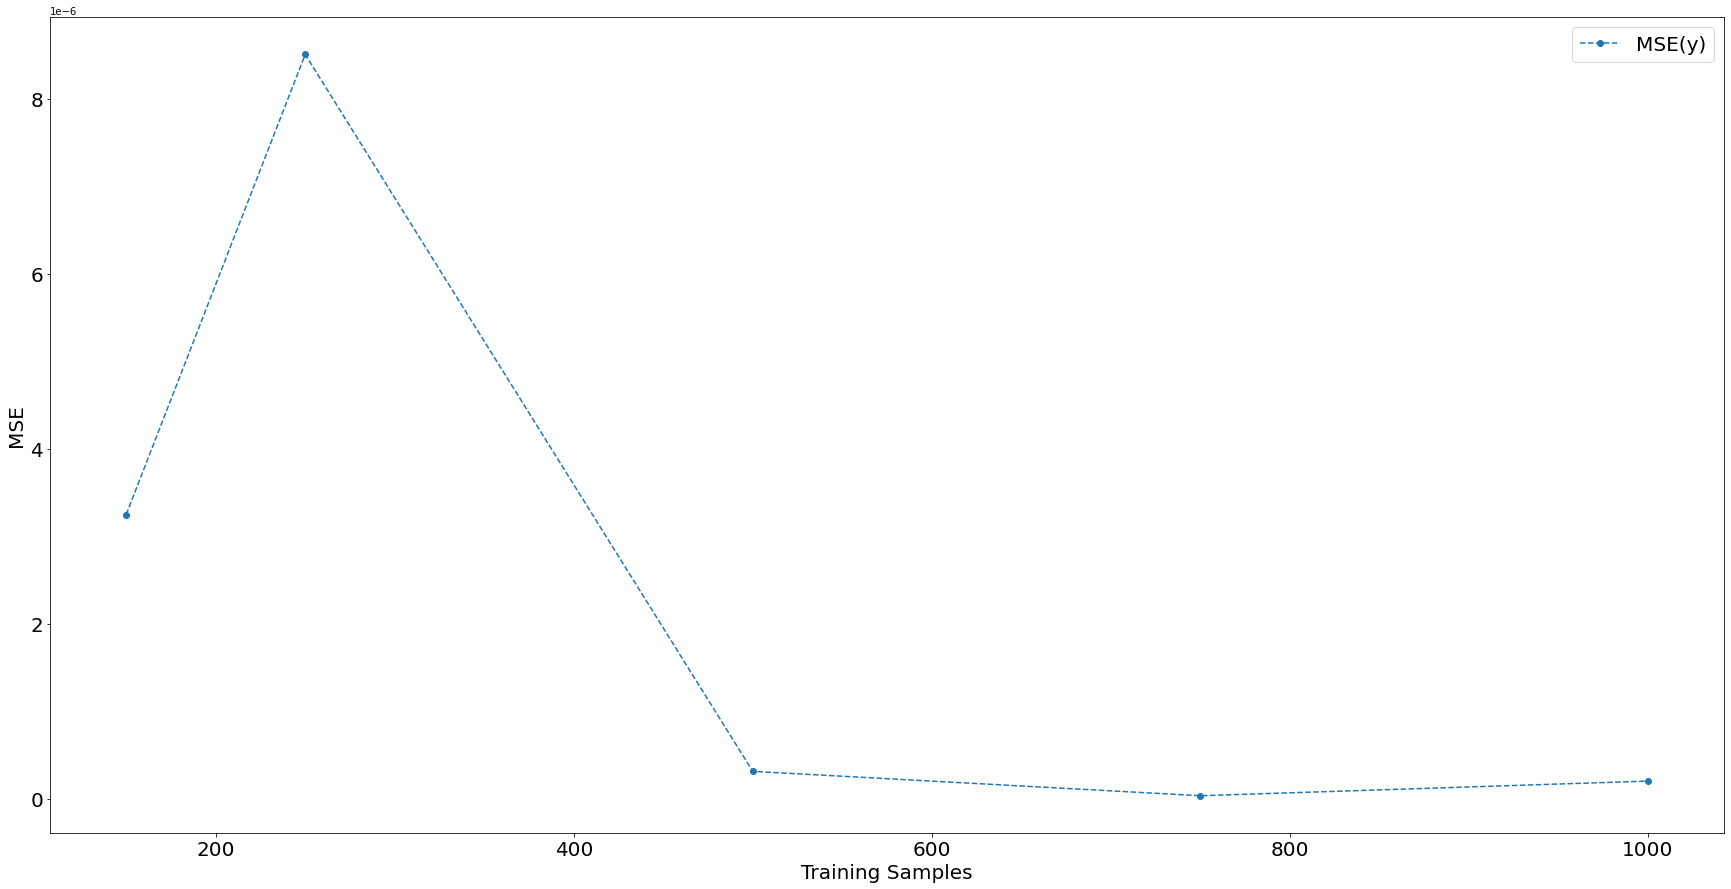


Data:
sample number  =  0
sample number  =  1000
sample number  =  2000
sample number  =  3000
sample number  =  4000
sample number  =  5000
sample number  =  6000
sample number  =  7000
sample number  =  8000
sample number  =  9000
82.21795797348022
GP_BW_SDOF_150_L_0.05_S_125
4.231100559234619
GP_BW_SDOF_250_L_0.05_S_125
3.1345930099487305
GP_BW_SDOF_500_L_0.05_S_125
3.0592234134674072
GP_BW_SDOF_750_L_0.05_S_125
3.007258415222168
GP_BW_SDOF_1000_L_0.05_S_125
3.0228116512298584


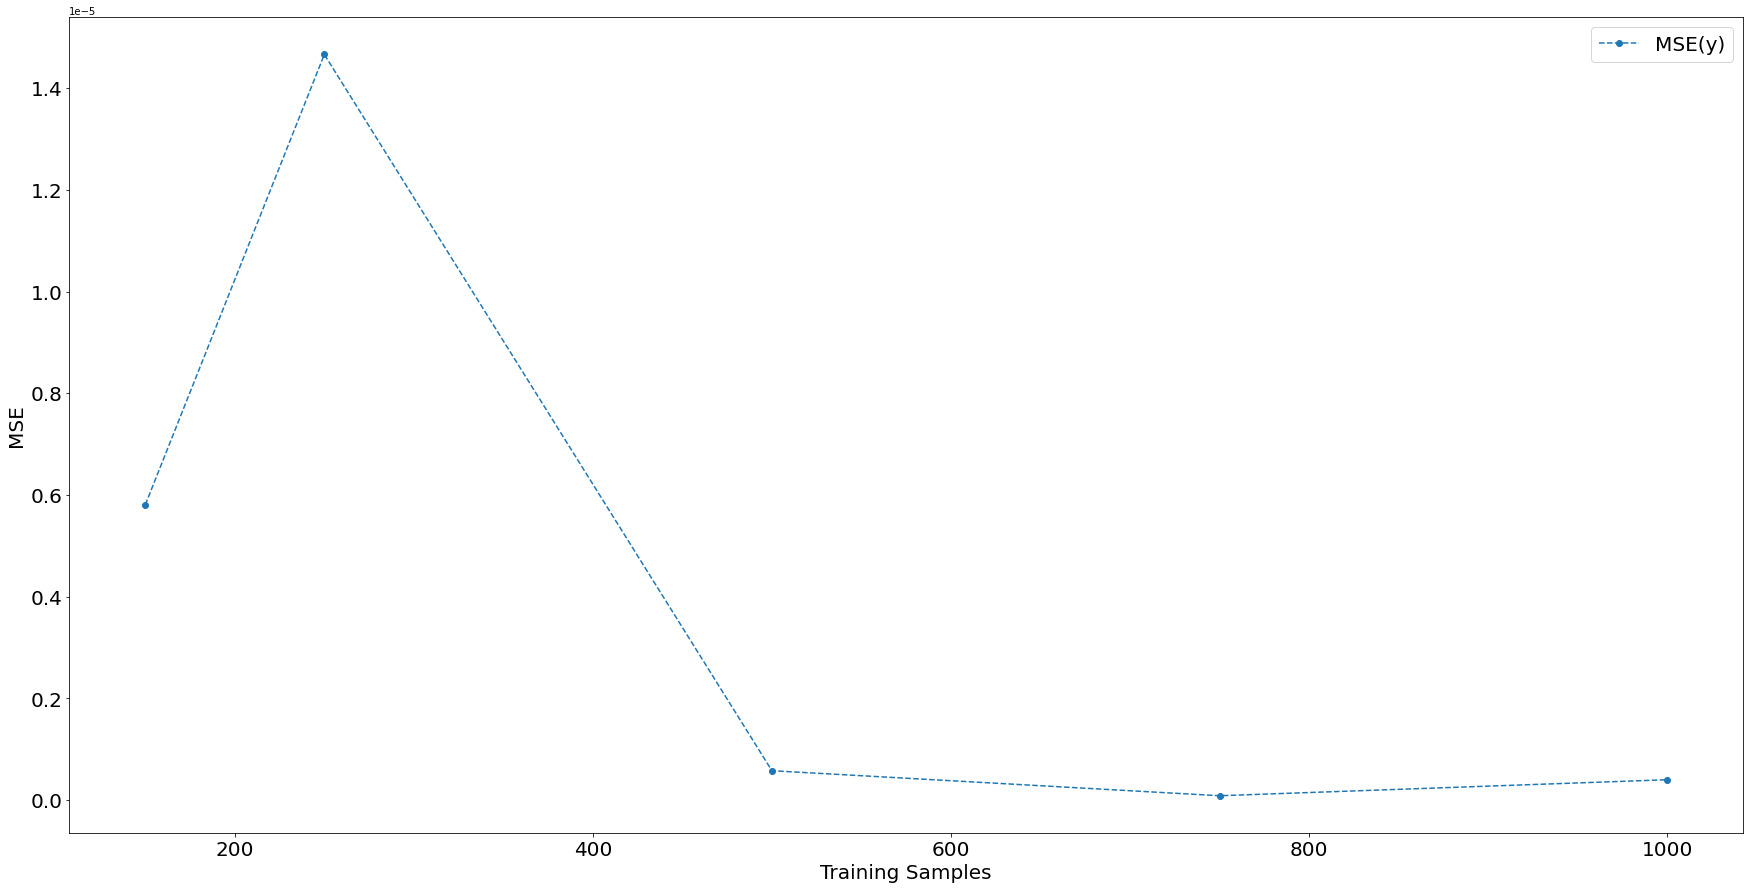

In [3]:
%reset -f

import numpy as np
import scipy.io as sp
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Model
from keras.layers.merge import concatenate
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.layers import Dense, Input, Lambda, Dot
from tensorflow.keras.layers.experimental import preprocessing
import time


with tf.device('/device:cpu:0'):

    def rkm(y1, y2, z, f, t):
        h = dt

        F1 = lambda Y: Y[2]
        F2 = lambda Y: (1/m)*(f-(c*Y[2]+k*Y[1]+(1-kr)*Qy*Y[3]))
        F3 = lambda Y: (1/Dy)*(alpha*Y[2]-gamma*Y[3]*np.abs(Y[2])*np.abs(Y[3])**(eta-1)-beta*Y[2]*(np.abs(Y[3]))**eta)    

        k0 = h*F1([t, y1, y2, z]);
        l0 = h*F2([t, y1, y2, z]);
        m0 = h*F3([t, y1, y2, z]);

        k1 = h*F1([t+0.5*h, y1+0.5*k0, y2+0.5*l0, z+0.5*m0]);
        l1 = h*F2([t+0.5*h, y1+0.5*k0, y2+0.5*l0, z+0.5*m0]);
        m1 = h*F3([t+0.5*h, y1+0.5*k0, y2+0.5*l0, z+0.5*m0]);

        k2 = h*F1([t+0.5*h, y1+0.5*k1, y2+0.5*l1, z+0.5*m1]);
        l2 = h*F2([t+0.5*h, y1+0.5*k1, y2+0.5*l1, z+0.5*m1]);
        m2 = h*F3([t+0.5*h, y1+0.5*k1, y2+0.5*l1, z+0.5*m1]);

        k3 = h*F1([t, y1+k2, y2+l2, z+m2]);
        l3 = h*F2([t, y1+k2, y2+l2, z+m2]);
        m3 = h*F3([t, y1+k2, y2+l2, z+m2]);

        y1 = y1+(1/6)*(k0+2*k1+2*k2+k3);
        y2 = y2+(1/6)*(l0+2*l1+2*l2+l3);
        z = z+(1/6)*(m0+2*m1+2*m2+m3);

        return y1, y2, z
    
    predicted = np.zeros([10000,200])
    x_test_0_new = np.zeros([2000000, 100])
    x_test_1_new = np.zeros([2000000, 1])
    
#     l_terms = [0.075, 0.075, 0.075, 0.075, 0.075,
#                0.1, 0.1, 0.1, 0.1, 0.1,
#                0.25, 0.25, 0.25, 0.25, 0.25,
#                0.5, 0.5, 0.5, 0.5, 0.5,
#                0.75, 0.75, 0.75, 0.75, 0.75]
        
#     s_terms = [25, 50, 75, 100, 125,
#                25, 50, 75, 100, 125,
#                25, 50, 75, 100, 125,
#                25, 50, 75, 100, 125,
#                25, 50, 75, 100, 125]

#     for l_s_num in range(0,25):

    l_terms = [0.05, 0.05, 0.05, 0.05, 0.05]
        
    s_terms = [25, 50, 75, 100, 125]

    for l_s_num in range(0,5):

        dt = 0.01
        min_t = 0
        max_t = 2

        t = np.arange(min_t, max_t, dt)
        lt = t.shape[0]

        test_samples = 10000

        y1 = np.zeros([lt, test_samples])+0.005
        y2 = np.zeros([lt, test_samples])+0.001
        z = np.zeros([lt, test_samples])+0.001

        l = l_terms[l_s_num]
        s = s_terms[l_s_num]

        mean = np.zeros([lt,])
        cov = np.zeros([lt,lt])

        f = np.zeros([lt, test_samples])
        for i in range(0,lt):
            for j in range(i,lt):
                cov[i,j] = (s**2)*np.exp(-1*((t[i]-t[j])**2)/(2*l**2))
                cov[j,i] = cov[i,j] 
                
        f = np.random.multivariate_normal(mean, cov, test_samples).T

        m = 6800; c = 3740; k = 232000
        Qy = 0.05*m*9.81; kr = (1/6); alpha = 1
        beta = 0.5; gamma = 0.5; Dy = 0.013; eta = 2 
        
        start_time = time.time()
        print('\nData:')
        
        for i in range(0, test_samples):
            if i%1000 ==  0: print('sample number  = ', i) 
            for j in range(1, lt):
                y1[j, i], y2[j, i], z[j, i] = rkm(y1[j-1, i], y2[j-1, i], z[j-1, i], f[j-1, i], t[j-1])
        print(time.time()-start_time)

        string = 'GP_BW_SDOF_testing_data_L_'+str(l)+'_S_'+str(s)+'.mat'
        sp.savemat(string,{'force': f, 'y1': y1, 'y2': y2, 'z': z, 'l':l, 's':s})

        x_test = f[0:-1:2,:].T

        training_samples = [150, 250, 500, 750, 1000]
        mean_sq_error = np.zeros([1,5])

        y = y1.T
        
        for model_num in range(0,5):
            string = 'model_save_GP_BW_SDOF_'+str(training_samples[model_num])
            model = tf.keras.models.load_model(string)
            print('GP_BW_SDOF_'+str(training_samples[model_num])+'_L_'+str(l)+'_S_'+str(s))

            start_time = time.time()
            for i in range(0,test_samples):
                x_test_0_new[lt*i:lt+lt*i,:] = np.tile(x_test[i,:],[200,1])
                x_test_1_new[lt*i:lt+lt*i,:] = t.reshape([lt,1])
                
            predictions_new = model({"input_a":x_test_0_new,
                                     "input_b":x_test_1_new})

            predictions_new = np.array(predictions_new)
            for i in range(0,test_samples):
                predicted[i,:] = predictions_new[lt*i:lt+lt*i].reshape(1,-1)
            print(time.time()-start_time)

            string = 'GP_BW_SDOF_training_samples_'+str(training_samples[model_num])+'_L_'+str(l)+'_S_'+str(s)+'.mat' 
            sp.savemat(string,{'actual_y': y, 'predicted_y': predicted, 'model_num': training_samples[model_num], 'l':l, 's':s})

            error = (y-predicted)
            mean_sq_error[0, model_num] = np.mean(error**2)

        plt.figure(figsize = [30,15])

        string = 'MSE(y)'
        plt.plot(training_samples,mean_sq_error[0,:], 'o--', label = string)

        plt.xlabel('Training Samples',fontsize = 20)
        plt.ylabel('MSE',fontsize = 20)
        plt.tick_params(axis = 'x', labelsize = 20)
        plt.tick_params(axis = 'y', labelsize = 20)
        plt.legend(fontsize = 20)
        plt.show()